# Implementing a reparameterized Beta sampler
@fritzo 2017-11-30

This notebook derives the `beta_grad(x,alpha,beta)` function that is used to compute reparameterized gradients in `torch.distributions.Beta().sample()`. This is an alternative to the naive stochastic reparameterized gradient estimator based on `Gamma().sample()` gradients.

In [1]:
import os
import torch
from torch.autograd import Variable
import itertools
import numbers
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
from matplotlib import pyplot
from torch.distributions import Beta, Normal
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

def expand_all(*args):
    zero = np.zeros(np.broadcast(*args).shape)
    return tuple(zero + arg for arg in args)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha,beta). This is based on the following definition. Let $x\sim Beta(\alpha,\beta)$ be a Beta random variable. The the reparameterized gradient wrt $\alpha$ is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [3]:
def dx_dalpha(x, alpha, beta):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.beta.cdf
    pdf = scipy.stats.beta.pdf
    if isinstance(alpha, numbers.Number):
        alpha = np.array([alpha])
    eps = alpha * 0.04
    eps[alpha > 10] = alpha[alpha > 10] ** 0.5 * 0.02
    d_dalpha = (cdf(x, alpha + eps, beta) - cdf(x, alpha - eps, beta)) / (2 * eps)
    d_dx = pdf(x, alpha, beta)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

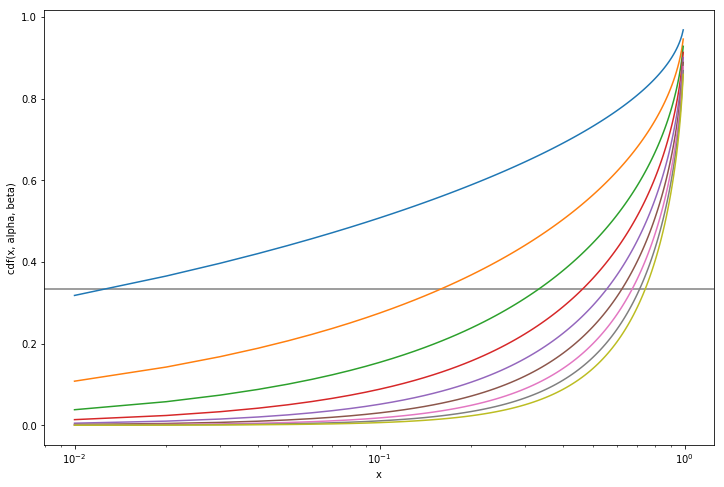

In [4]:
x = np.arange(0, 1, 0.01)
pyplot.figure(figsize=(12,8))
pyplot.axhline(0.333, color='gray')
beta = 0.5
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(x, scipy.stats.beta.cdf(x, alpha, beta))
pyplot.xscale('log')
pyplot.xlabel('x')
pyplot.ylabel('cdf(x, alpha, beta)')
pyplot.show()

In [5]:
digamma = scipy.special.digamma

def dx_dalpha_small_v1(x, alpha, beta):
    return x / alpha * (1.0 / alpha + digamma(alpha) - digamma(alpha + beta) - np.log(x))
def dx_dbeta_small(x, alpha, beta):
    return x / alpha * (digamma(beta) - digamma(alpha + beta))
def dx_dalpha_small_v2(x, alpha, beta):
    # Add one higher-order term.
    total = alpha + beta
    return (digamma(alpha) - digamma(total) + 1/alpha - np.log(x) - (beta-1)/(alpha+1)**2*x) \
        * (x/alpha * (1 + x * (beta-1)/(alpha+1)))
def dx_dalpha_small_valid(x, alpha, beta):
    return x * (1.0 + alpha + beta) < 0.02
dx_dalpha_small = dx_dalpha_small_v2

def dx_dalpha_large_v1(x, alpha, beta):
    # Equivalent to:
    # return -dx_dbeta_small(1.0 - x, beta, alpha)
    total = alpha + beta
    return (digamma(total) - digamma(alpha)) * (1-x) / beta
def dx_dalpha_large_v2(x, alpha, beta):
    total = alpha + beta
    return (digamma(total) - digamma(alpha)) / beta * (1-x) * x
def dx_dalpha_large_valid(x, alpha, beta):
    return 0.98 < x
dx_dalpha_large = dx_dalpha_large_v2

# This uses a Laplace approximation in log(x/(1-x)) coordinates.
def dx_dalpha_mid_v1(x, alpha, beta):
    total = alpha + beta
    logit = x / (1 - x)
    Logit = alpha / beta
    return x * (1 - x) * (
        1.0 / alpha - np.log(logit / Logit) / (2 * Logit * total)
    )
def dx_dalpha_mid_v2(x, alpha, beta):
    total = alpha + beta
    logit = x / (1 - x)
    Logit = alpha / beta
    t = 0.5 * beta/total
    # return x * (1-x) / alpha / r ** (0.5 * beta/total)
    # return (x/alpha)**(1-t) * ((1-x)/beta)**t * (1-x)
    return (x/alpha)**(1-t) * ((1-x)/beta)**t * (1-x)
def dx_dalpha_mid_valid(x, alpha, beta):
    x, alpha, beta = expand_all(x, alpha, beta)
    return (alpha >= 50) & (beta >= 50)
dx_dalpha_mid = dx_dalpha_mid_v2

In [6]:
LB, UB = 1e-4, 1e3
alphas = LB * (UB / LB) ** np.random.random(10000)
betas = LB * (UB / LB) ** np.random.random(10000)
xs = scipy.stats.beta.rvs(alphas, betas)
truth = dx_dalpha(xs, alphas, betas)
approximations = [
    ('small1', dx_dalpha_small_v1, dx_dalpha_small_valid),
    ('small2', dx_dalpha_small_v2, dx_dalpha_small_valid),
    ('large1', dx_dalpha_large_v1, dx_dalpha_large_valid),
    ('large2', dx_dalpha_large_v2, dx_dalpha_large_valid),
    ('mid1', dx_dalpha_mid_v1, dx_dalpha_mid_valid),
    ('mid2', dx_dalpha_mid_v2, dx_dalpha_mid_valid),
]
print('\t'.join(['version', 'max_err', 'rms_err',
                 'alpha', 'beta', 'x', 'truth', 'approx', 'volume']))
print('-' * 9 * 8)
for name, approx_fn, is_valid in approximations:
    w = is_valid(xs, alphas, betas) & (truth > 0)
    approx = approx_fn(xs[w], alphas[w], betas[w])
    error = np.abs(approx - truth[w]) / (1e-10 + truth[w])
    i = np.argmax(error)
    print('{}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}'.format(
        name, error.max(), (error**2).mean()**0.5,
        alphas[w][i], betas[w][i], xs[w][i], truth[w][i], approx[i], w.mean()))

version	max_err	rms_err	alpha	beta	x	truth	approx	volume
------------------------------------------------------------------------
small1	0.024	0.0025	0.0033	76	0.00025	0.26	0.26	0.23
small2	0.018	0.0011	0.98	63	4.4e-06	3.9e-05	3.9e-05	0.23
large1	0.016	0.0029	0.11	0.093	0.98	0.93	0.94	0.14
large2	0.01	0.0027	2.7e+02	4.4	0.98	7.3e-05	7.2e-05	0.14
mid1	0.025	0.0039	52	2.4e+02	0.12	0.0024	0.0024	0.036
mid2	0.014	0.0029	77	91	0.56	0.0029	0.0029	0.036


/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:400: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a, b))


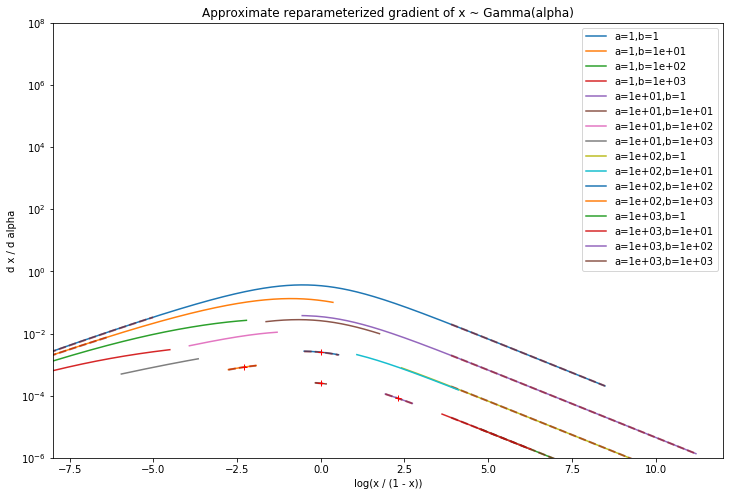

In [7]:
pyplot.figure(figsize=(12, 8))
grid = [
    #1e-4, 1e-2,
    1e0, 1e1, 1e2, 1e3,
]
for alpha, beta in itertools.product(grid, grid):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / (1 - x))
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)),
                label='a={:0.1g},b={:0.1g}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small_v1(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_small_v2(x[w], alpha, beta), 'r--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large_v1(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_large_v2(x[w], alpha, beta), 'r--', lw=2, alpha=0.3)
    w = dx_dalpha_mid_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_mid_v1(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_mid_v2(x[w], alpha, beta), 'r--', lw=2, alpha=0.3)
    if w.any():
        pyplot.plot([np.log(alpha / beta)],
                    [dx_dalpha_mid(alpha / (alpha + beta), alpha, beta)], 'r+')
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-8, 12)
pyplot.ylim(1e-6, 1e8)
pyplot.legend()
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


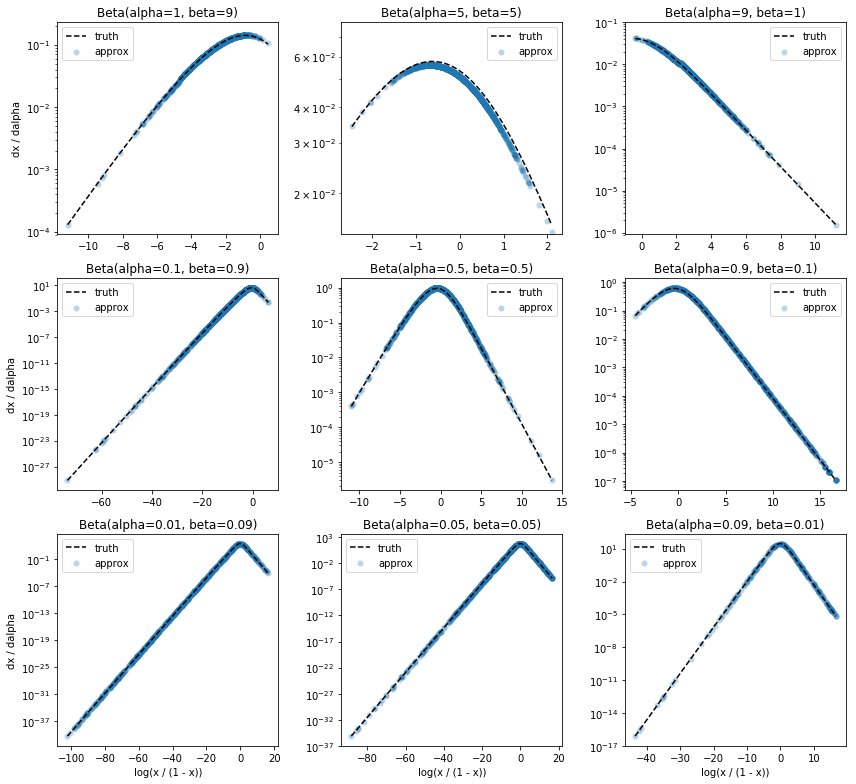

In [8]:
set_seed(0)
fig, axes = pyplot.subplots(3, 3, figsize=(12,11))
alpha_grid = [1.0, 5.0, 9.0, 0.1, 0.5, 0.9, 0.01, 0.05, 0.09]
beta_grid = [9.0, 5.0, 1.0, 0.9, 0.5, 0.1, 0.09, 0.05, 0.01]
ones = torch.ones(1000)
for i, (ax, alpha, beta) in enumerate(zip(axes.reshape(-1), alpha_grid, beta_grid)):
    alphas = Variable(alpha * ones, requires_grad=True)
    betas = Variable(beta * ones)
    x = Beta(alphas, betas).sample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    u = np.log(x / (1 - x))
    actual_grad = alphas.grad.data[ind].numpy()
    ax.scatter(u, actual_grad, alpha=0.3, label='approx', lw=0)
    ax.plot(u, dx_dalpha(x, alpha, beta), 'k--', label='truth')
    ax.set_yscale('log')
    ax.set_title('Beta(alpha={:0.1g}, beta={:0.1g})'.format(alpha, beta))
    if i >= 6:
        ax.set_xlabel('log(x / (1 - x))')
    if i % 3 == 0:
        ax.set_ylabel('dx / dalpha')
    ax.legend()
pyplot.tight_layout()
pyplot.savefig(os.path.expanduser('~/Downloads/beta-reparameterized.png'))
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is.

In [9]:
n = 10
dist = Beta(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
            Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 1.35 s, sys: 75.9 ms, total: 1.42 s
Wall time: 1.43 s
---- Backward ----
CPU times: user 2.36 s, sys: 153 ms, total: 2.52 s
Wall time: 2.53 s


Here's a Normal distribution for comparison.

In [10]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
# %time x = dist.sample(requires_grad=True)
# print('---- Backward ----')
# %time x.sum().backward()

---- Forward ----
CPU times: user 465 ms, sys: 37.4 ms, total: 502 ms
Wall time: 437 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha, beta)` that we want to approximate.

Let's approximate using a trivariate rational function of $\log(x/(1-x))$, $\log(\alpha)$, and $\log(\beta)$. We'll approximate using quadratic $4 x(1-x)$ nonlinearity.

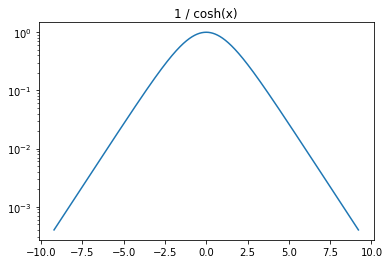

In [11]:
x = np.arange(0.0001, 1.0, 0.0001)
pyplot.plot(np.log(x / (1-x)), 4*x*(1-x))
pyplot.yscale('log')
pyplot.title('1 / cosh(x)')
pyplot.show()

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:1

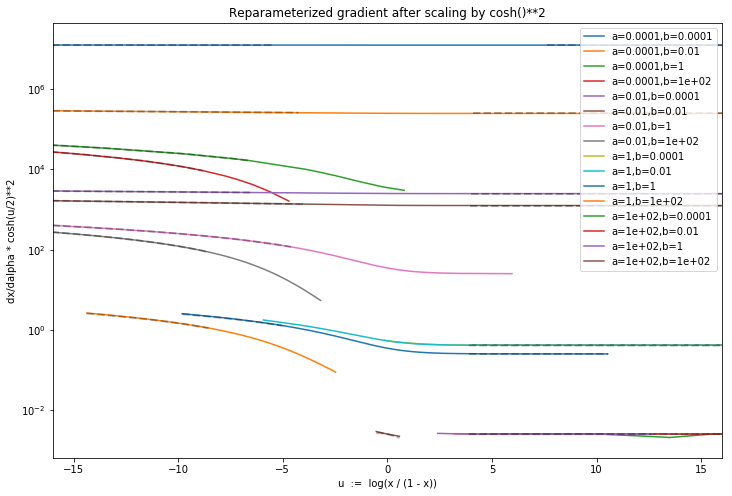

In [12]:
pyplot.figure(figsize=(12, 8))
for alpha, beta in itertools.product([1e-4, 1e-2, 1e0, 1e2], [1e-4, 1e-2, 1e0, 1e2]):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / (1 - x))
    #g0 = np.cosh(0.5 * u) ** -2
    g0 = 4 * x * (1 - x)
    pyplot.plot(u, dx_dalpha(x, alpha, beta) / g0,
                label='a={:0.1g},b={:0.1g}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small(x[w], alpha, beta) / g0[w], 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large(x[w], alpha, beta) / g0[w], 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_mid_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_mid(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
pyplot.title('Reparameterized gradient after scaling by cosh()**2')
pyplot.xlabel('u  :=  log(x / (1 - x))')
pyplot.ylabel('dx/dalpha * cosh(u/2)**2')
pyplot.yscale('log')
pyplot.xlim(-16, 16)
pyplot.legend()
pyplot.show()

This suggests a polynomial approximation of the center of the plot.

In [37]:
order = (4, 4, 4)
K = order[0] * order[1] * order[2]  # number of training parameters
def dx_dalpha_approx(x, alpha, beta, coef):
    x, alpha, beta = expand_all(x, alpha, beta)
    coef = coef.reshape(order)
    u = np.log(x / (1.0 - x))
    a = np.log(alpha)
    b = np.log(alpha + beta)
    us = [1.0, u, u * u, u * u * u]
    As = [1.0, a, a * a, a * a * a, a * a * a * a]
    bs = [1.0, b, b * b, b * b * b, b * b * b * b]
    poly = 0.0
    for i in range(order[0]):
        for j in range(order[1]):
            for k in range(order[2]):
                poly += coef[i][j][k] * us[i] * As[j] * bs[k]
    baseline = np.cosh(0.5 * u)
    return np.exp(poly) / (baseline * baseline)

### Constructing training data

We construct a stratified training set to balance the non-asymptotic data points among all $(\alpha,\beta)$ pairs.

In [38]:
np.random.seed(sum(order))  # Warm start with different data.
size_train = 5000
LB, UB, grid_size = 1e-4, 1e3, 16
grid = LB * (UB / LB) ** (np.array(range(grid_size)) / (grid_size - 1.0))
alpha_bins, beta_bins, x_bins = [], [], []
bin_size = size_train / len(grid) ** 2
for alpha, beta in itertools.product(grid, grid):
    alpha_train = alpha * np.ones(20 * size_train)
    beta_train = beta * np.ones(20 * size_train)
    x_train = scipy.stats.beta.rvs(alpha_train, beta_train)
    valid = ~(dx_dalpha_small_valid(x_train, alpha_train, beta_train) |
              dx_dalpha_large_valid(x_train, alpha_train, beta_train) |
              dx_dalpha_mid_valid(x_train, alpha_train, beta_train))
    valid = valid.nonzero()[0]
    valid = valid[:bin_size]
    if len(valid) < bin_size:
        print('Warning: only {}/{} samples collected for alpha={:0.2g}, beta={:0.2g}'.format(
        len(valid), bin_size, alpha, beta))
    alpha_bins.append(alpha_train[valid])
    beta_bins.append(beta_train[valid])
    x_bins.append(x_train[valid])

alpha_train = np.concatenate(alpha_bins)
beta_train = np.concatenate(beta_bins)
x_train = np.concatenate(x_bins)
grad_train = dx_dalpha(x_train, alpha_train, beta_train)
print('Data size = {}'.format(len(grad_train)))

Data size = 4234


In [39]:
def approx_objective(coeff):
    approx = dx_dalpha_approx(x_train, alpha_train, beta_train, coeff).reshape(-1)
    return 1 - approx / grad_train

We'll warm start higher-order solutions with a low-order solution.

In [40]:
coef0 = np.zeros(K)

coef333 = np.array([-0.57172642659729744, -0.57283810757586784, 0.016926232518376671, -0.86338544801509942, 0.060613129254311081, -0.0044996601715673826, 0.010168337140552368, 0.0037232856662320793, -0.00051224194305560169, -0.12264081437555875, -0.048905452787208814, 0.0021592782621524518, 0.032724743176275002, -0.0010534445704699113, 0.00021711833179521845, 0.0027979350631756389, -0.00025893240479964239, -6.0096265311999667e-05, 0.019614720203210992, -0.0012464748278219358, -0.00020229234514382438, 0.0025934076088883263, -0.00076065342825665477, 0.00010443695460504852, 0.00029139670014010049, -9.3070625134960725e-05, 4.9287383270292105e-06])
coef333 = coef333.reshape((3, 3, 3))
if order[0] >= 3 and order[1] >= 3 and order[2] >= 3:
    coef0.reshape(order)[:3, :3, :3] = coef333

coef344 = np.array([-0.57940623411611791, -0.62135899538169792, 0.024111316687367036, -0.0079115217894659088, -0.79773600489957475, 0.053138694745260957, 0.0034759556068840488, 0.00012389563002401604, 0.031773534009929168, 0.0012916698998486282, -0.0011721221847258083, 0.00017364162434782508, 0.001559620626607066, -0.00025249074463786793, -0.00016561585622291034, 6.6142062719611754e-06, -0.13962544405354185, -0.05260130005130105, -0.01458390235346366, 0.00065431410799401935, 0.018588003019695709, 0.019818251670733599, -0.00099075054833250189, 8.6676258380166372e-06, -0.002629689492479994, 0.0013275235282700425, -1.3228060553323055e-05, -1.0888546519113024e-06, -0.00038637583250173335, -6.715039132776653e-05, -7.1720425681951906e-06, -5.0324766547853479e-08, 0.019594770287979773, 0.0020390685362378326, -0.0037492046646841076, 0.00033498659083650641, 0.0034965895798524014, 0.0039160076278463062, -0.0010543585737392254, 8.133314986938165e-05, -0.0001263831258171296, 0.00054004778700365841, -0.00012854864738449584, 1.0755957864234285e-05, -3.7212154600771098e-05, 1.6621788019962996e-05, -6.0911012010317887e-06, 6.4042540696304627e-07])
coef344 = coef344.reshape((3, 4, 4))
if order[0] >= 3 and order[1] >= 4 and order[2] >= 4:
    coef0.reshape(order)[:3, :4, :4] = coef344

In [41]:
soln = scipy.optimize.least_squares(approx_objective, coef0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coef = soln.x
print(soln)
print('coeff = {}'.format(list(coef)))
error = approx_objective(coef)
print('error = {:0.3g} rms, {:0.3g} max'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max()))

 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
        cost: 5.2062839291421525
         fun: array([-0.01525608, -0.0150706 , -0.06952563, ...,  0.05998676,
        0.01624928,  0.07864016])
        grad: array([ -1.37450640e+00,   7.35528569e+00,  -2.07033331e+01,
        -9.27236979e+01,   1.35449238e+01,   3.00342837e+01,
         3.90452777e+02,   2.32157960e+03,  -1.51526616e+00,
         1.14461028e+02,   8.56922290e+02,   2.00067810e+03,
         1.54699485e+02,   2.30819423e+03,   1.48860928e+03,
         5.54547568e+04,   7.52279446e+00,   6.55035405e+01,
         3.66886460e+02,   3.07777678e+03,  -4.56154099e+01,
        -1.73545462e+02,   3.43127121e+02,  

Here's a per-region version that's closer our C implementation:

In [42]:
def dx_dalpha_final(x, alpha, beta):
    x, alpha, beta = expand_all(x, alpha, beta)
    result = dx_dalpha_approx(x, alpha, beta, coef)
    w = dx_dalpha_small_valid(x, alpha, beta)
    result[w] = dx_dalpha_small(x[w], alpha[w], beta[w])
    w = dx_dalpha_large_valid(x, alpha, beta)
    result[w] = dx_dalpha_large(x[w], alpha[w], beta[w])
    w = dx_dalpha_mid_valid(x, alpha, beta)
    result[w] = dx_dalpha_mid(x[w], alpha[w], beta[w])
    return result

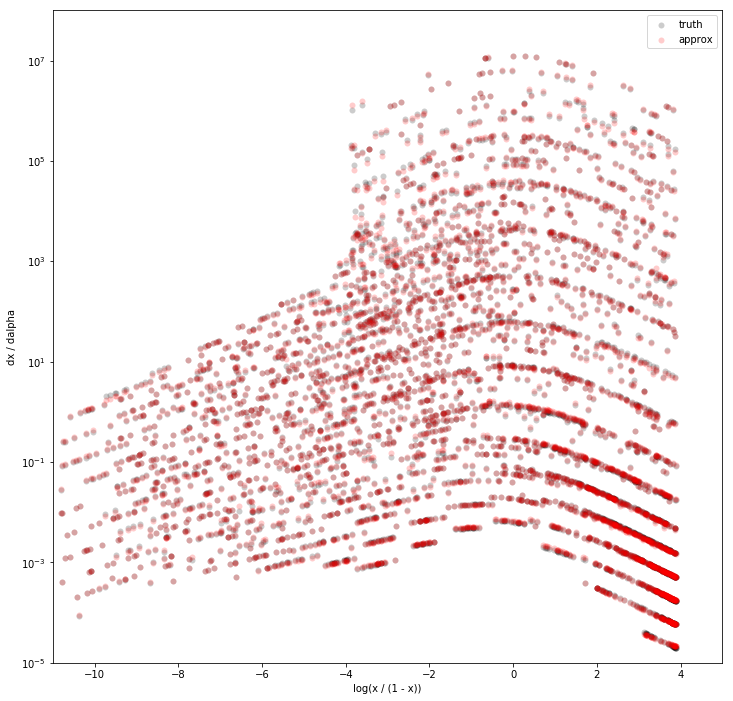

In [43]:
grad_approx = dx_dalpha_final(x_train, alpha_train, beta_train)
u = np.log(x_train / (1 - x_train))
pyplot.figure(figsize=(12, 12))
pyplot.scatter(u, grad_train, color='black', lw=0, alpha=0.2, label='truth')
pyplot.scatter(u, grad_approx, color='red', lw=0, alpha=0.2, label='approx')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('dx / dalpha')
pyplot.yscale('log')
pyplot.xlim(-11, 5)
pyplot.ylim(1e-5, 1e8)
pyplot.legend()
pyplot.show()

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encounter

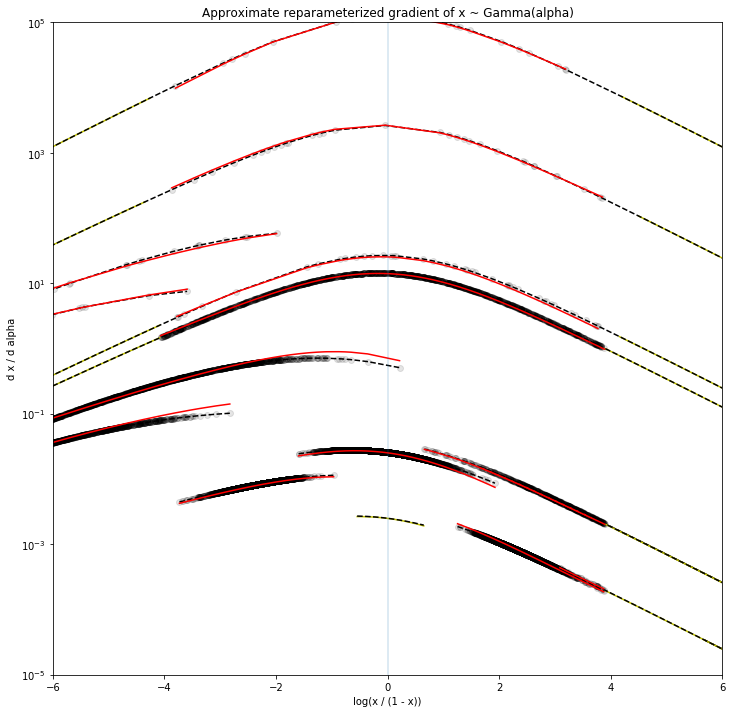

In [44]:
pyplot.figure(figsize=(12, 12))
ones = np.ones(5000)
for alpha, beta in itertools.product([1e-3, 1e-1, 1e1, 1e2], [1e-3, 1e-1, 1e1, 1e2]):
    x = scipy.stats.beta.rvs(ones * alpha, ones * beta)
    x.sort()
    u = np.log(x / (1 - x))
    w1 = dx_dalpha_small_valid(x, alpha, beta)
    w2 = dx_dalpha_large_valid(x, alpha, beta)
    w3 = dx_dalpha_mid_valid(x, alpha, beta)
    w = ~(w1 | w2 | w3)
    pyplot.plot(u[w1], np.maximum(1e-20, dx_dalpha_final(x[w1], alpha, beta)), 'y-')
    pyplot.plot(u[w2], np.maximum(1e-20, dx_dalpha_final(x[w2], alpha, beta)), 'y-')
    pyplot.plot(u[w3], np.maximum(1e-20, dx_dalpha_final(x[w3], alpha, beta)), 'y-')
    pyplot.scatter(u[w], np.maximum(1e-20, dx_dalpha(x[w], alpha, beta)),
                   color='black', alpha=0.1)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), 'k--')
    pyplot.plot(u[w], np.maximum(1e-20, dx_dalpha_final(x[w], alpha, beta)), 'r-')
pyplot.axvline(0, alpha=0.2)
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-6, 6)
pyplot.ylim(1e-5, 1e5)
pyplot.legend()
pyplot.show()

Finally, let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [45]:
print('static const double coef[{}][{}][{}] = {{{{'.format(*order))
for i, block in enumerate(coef.reshape(order)):
    if i:
        print('  }, {')
    for row in block:
        print('    {' + ', '.join(map('{:0.8g}'.format, row)) + '},')
print('}};')

static const double coef[4][4][4] = {{
    {-0.57940636, -0.62136142, 0.024109699, -0.007926795},
    {-0.7977348, 0.053146104, 0.0034583072, 7.7873386e-05},
    {0.031760342, 0.0012499557, -0.0011770801, 0.00019385517},
    {0.0016715776, -0.00024217922, -0.00018358743, 7.1795596e-06},
  }, {
    {-0.13962373, -0.052597078, -0.014576002, 0.00060780217},
    {0.018589183, 0.019812249, -0.0010491959, -2.6090671e-05},
    {-0.0026281648, 0.0013034393, 6.017623e-06, 8.9232037e-06},
    {-0.00044045144, -0.00011634014, -1.3853762e-05, 8.7995645e-07},
  }, {
    {0.019596715, 0.0020388963, -0.0037901844, 0.00033437256},
    {0.0034989411, 0.0038837343, -0.0010386102, 7.3795545e-05},
    {-0.00012202688, 0.00064103677, -9.0266953e-05, 5.2563659e-06},
    {-8.5008046e-05, 6.8625294e-06, -2.7273944e-06, 2.8966612e-07},
  }, {
    {5.8978657e-05, 0.00010074944, -4.4009615e-05, 4.1580522e-06},
    {3.551158e-05, -1.9925897e-05, -9.3562288e-06, 1.9964568e-06},
    {4.916296e-05, -9.537723e-06, 2.